#Importing Libraries

In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import time

#Taking our content image and style image

In [3]:
content_path="/content/contentimage.jpe"   
style_path="/content/styleimage.jpe"
#As I did it on google colab, the two images should be there in corresponding google drive

In [4]:
a=tf.io.read_file(style_path)
a=tf.image.decode_image(a, channels=3)

In [5]:
a

<tf.Tensor: shape=(186, 271, 3), dtype=uint8, numpy=
array([[[150, 189,  98],
        [133, 163,  75],
        [146, 158,  76],
        ...,
        [214,  93,  82],
        [220,  97,  82],
        [228,  98,  82]],

       [[150, 193, 101],
        [151, 186,  96],
        [166, 179,  97],
        ...,
        [211,  89,  76],
        [209,  83,  68],
        [218,  86,  71]],

       [[119, 173,  77],
        [170, 211, 119],
        [185, 203, 119],
        ...,
        [217,  89,  76],
        [222,  90,  75],
        [226,  89,  73]],

       ...,

       [[  2, 184,  14],
        [  2, 184,  14],
        [  0, 182,  12],
        ...,
        [179,  99,  38],
        [180,  94,  35],
        [188,  95,  38]],

       [[  2, 182,  13],
        [  6, 186,  17],
        [ 14, 194,  25],
        ...,
        [203, 122,  59],
        [190, 101,  41],
        [187,  91,  33]],

       [[  2, 182,  13],
        [  6, 186,  17],
        [ 14, 194,  25],
        ...,
        [217, 136,  7

A tensor is a container which can house data
in N dimensions, along with its linear operations.


In [6]:
a=tf.io.read_file(content_path)     #Reads and outputs the entire contents of the input filename.
a=tf.image.decode_image(a, channels=3) #Detects whether an image is a BMP, GIF, JPEG, or PNG, 
#and performs the appropriate operation to convert the input bytes string into a Tensor of type dtype.
a

<tf.Tensor: shape=(667, 1000, 3), dtype=uint8, numpy=
array([[[211, 214, 219],
        [213, 216, 221],
        [216, 219, 224],
        ...,
        [236, 240, 243],
        [237, 241, 244],
        [239, 243, 246]],

       [[209, 212, 217],
        [211, 214, 219],
        [213, 216, 221],
        ...,
        [236, 240, 243],
        [237, 241, 244],
        [238, 242, 245]],

       [[206, 209, 214],
        [207, 210, 215],
        [208, 211, 216],
        ...,
        [236, 240, 243],
        [236, 240, 243],
        [237, 241, 244]],

       ...,

       [[ 24,  30,  26],
        [ 25,  31,  27],
        [ 26,  32,  28],
        ...,
        [ 17,  22,  18],
        [ 17,  22,  18],
        [ 17,  22,  18]],

       [[ 24,  30,  26],
        [ 25,  31,  27],
        [ 26,  32,  28],
        ...,
        [ 17,  22,  18],
        [ 17,  22,  18],
        [ 17,  22,  18]],

       [[ 24,  30,  26],
        [ 25,  31,  27],
        [ 26,  32,  28],
        ...,
        [ 17,  22,  

In [7]:
tf.shape(a)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 667, 1000,    3], dtype=int32)>

In [8]:
tf.shape(a)[:-1]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 667, 1000], dtype=int32)>

In [9]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)#reads the imagefrom its path.
  img = tf.image.decode_image(img, channels=3)#detects the type of image and converts it to tensor
  img = tf.image.convert_image_dtype(img, tf.float32) #converts the pixels to float

  shape = tf.cast(tf.shape(img)[:-1], tf.float32) #takes height and width as float
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]# increases the dimension
  return img

In [10]:
# to display an image


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

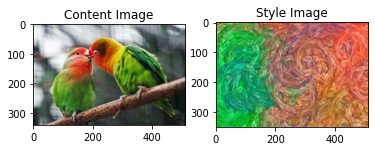

In [11]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [12]:
tf.shape(style_image)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 351, 512,   3], dtype=int32)>

In [13]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # taking vgg 19 model without the later output layers.

print()
for layer in vgg.layers:
  print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
vgg.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [15]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv4'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [16]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [17]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image)


#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 351, 512, 64)
  min:  0.0
  max:  4.3894343
  mean:  0.48183465

block2_conv1
  shape:  (1, 175, 256, 128)
  min:  0.0
  max:  21.20299
  mean:  1.7915564

block3_conv1
  shape:  (1, 87, 128, 256)
  min:  0.0
  max:  67.327995
  mean:  1.7711562

block4_conv1
  shape:  (1, 43, 64, 512)
  min:  0.0
  max:  149.80533
  mean:  8.661592

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  26.650108
  mean:  0.58090794



In [18]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) #forms the gram matrix.
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [19]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # ENCODES A BATCH OF IMAGES TO THE VGG19 MODEL
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}



#When called on an image,
# this model returns the gram matrix (style) of the style_layers and content of the content_layers

In [20]:
extractor = StyleContentModel(style_layers, content_layers)



In [21]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [22]:
# to-do:   create a random matrix wih the shape of content_image

In [23]:
image = tf.Variable(content_image)# IMAGE GENERATED

In [24]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


# SINCE THE MODEL ACCEPTS VALUES IN BETWEEN 0 AND 1 SO WE CLIP IT.

In [25]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#To optimize this, use a weighted combination of the two losses to get the total loss
style_weight=1e-2
content_weight=1e4

In [26]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) #reduce_mean Computes the mean of elements across dimensions of a tensor.
                           for name in style_outputs.keys()]) #add_n Adds all input tensors element-wise.
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [27]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [28]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [29]:
total_variation_weight=1e8

In [30]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))




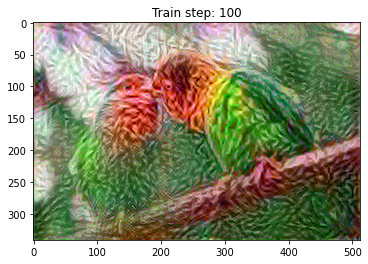

Total time: 555.3


In [31]:
import time
start = time.time()

epochs = 5
steps_per_epoch = 20

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=False)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))